In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import julian
#import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import linregress, kendalltau, spearmanr, pearsonr
import pickle

# EM-DAT data

In [3]:
# Load and format EM-DAT data
data = pd.read_excel(r'/home/jbaldwin/WorldBank/ASSET_LOSSES/emdat_2021_03_31_usa_TCs.xlsx', skiprows=6)

df = pd.DataFrame(data, columns= ['Event Name','Start Year','Start Month', 'Start Day', 'End Year','End Month', 'End Day', "Total Damages ('000 US$)"])
df = df[~np.isnan(df["Total Damages ('000 US$)"])] # select only data with damages

total_damages = np.array(df["Total Damages ('000 US$)"])*1000 # factor in the 1000 here so can ignore


# Dates only for data with damages
# Start and end dates
start_year = df['Start Year'].values*10000
start_month = df['Start Month'].values*100
start_day = df['Start Day'].values
start_date = (start_year+start_month+start_day).astype('int')
start_date = pd.to_datetime(start_date.astype(str),errors='coerce').values
# Start Date with only Year-Month because some day values missing
start_date_yearmonth = (start_year+start_month+1).astype('int')
start_date_yearmonth = pd.to_datetime(start_date_yearmonth.astype(str),errors='coerce').values

end_year = df['End Year'].values*10000
end_month = df['End Month'].values*100
end_day = df['End Day'].values
end_date = (end_year+end_month+end_day).astype('int')
end_date = pd.to_datetime(end_date.astype(str),errors='coerce').values
# End Date with only Year-Month because some day values missing
end_date_yearmonth = (end_year+end_month+1).astype('int')
end_date_yearmonth = pd.to_datetime(end_date_yearmonth.astype(str),errors='coerce').values

Text(0, 0.5, '# of Events')

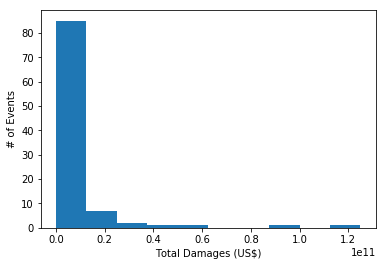

In [4]:
# Plot histogram of USA TC damages
plt.hist(total_damages)
plt.xlabel("Total Damages (US$)")
plt.ylabel('# of Events')

Text(0.5, 1.0, 'USA TCs in EMDAT')

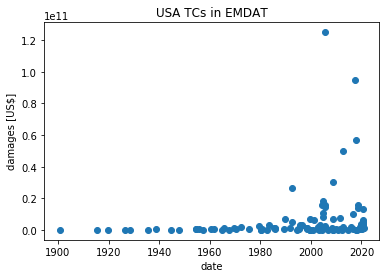

In [5]:
# Plot time series of USA TC damages
ax = plt.subplot(111)
plt.scatter(start_date_yearmonth,total_damages)
#ax.set_yscale('log')
#plt.xlim([np.min(start_date_yearmonth),np.max(start_date_yearmonth)])
plt.xlabel('date')
plt.ylabel('damages [US$]')
plt.title('USA TCs in EMDAT')
#plt.ylim([0,0.1e9])

# Modeled damage data

In [6]:
# Data files
direc = '/data2/jbaldwin/WINDFIELDS/IBTRACS/USA/ASSET_LOSSES/VCURVE_SENSITIVITY/'
#file_swaths = 'wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_2-10-21.nc'
file_damages = 'Vhalf-86_Vthresh-25.7.nc'

In [7]:
# Get dates from damage data
ds_damages = xr.open_dataset(direc + file_damages)
nmax = len(ds_damages.nS)
tc_start_date = ds_damages.start_date.values
tc_end_date = ds_damages.end_date.values
year = np.zeros(len(tc_start_date))
for i in range(len(tc_start_date)):
    year[i] = int(str(tc_start_date[i])[0:4])

In [8]:
%%time
# Match all with exact date match (Y-m-d)
nemax = len(start_date)
match = np.zeros((nemax,nmax))
for ne in range(nemax):
    if start_date[ne] == np.datetime64('NaT'):
        pass # skip if don't have day value
    else:
        emdat_range = pd.period_range(start_date[ne],end_date[ne])
        for nt in range(nmax):
            tc_range = pd.period_range(tc_start_date[nt],tc_end_date[nt])
            match[ne,nt] = sum(np.isin(tc_range,emdat_range)) # count number of days of overlap


# Select pairs where have greatest number of matches

# Value of greatest overlap
ne_max = np.max(match,axis=1)
ne_max_i = []
nt_max = np.max(match,axis=0)
nt_max_i = []


# Indices of place with greatest overlap
for ne in range(nemax):
    if ne_max[ne] == 0:
        pass
    else:
        ne_max_i.append([ne,np.where(match[ne,:] == ne_max[ne])[0]])
for nt in range(nmax):
    if nt_max[nt] == 0:
        pass
    else:
        nt_max_i.append([nt,np.where(match[:,nt] == nt_max[nt])[0]])

# Divide between clear match and ambiguous (multiple possible matches)
nt_max_i_clear = []
nt_max_i_ambi = []
for nn in range(len(nt_max_i)):
    if len(nt_max_i[nn][1]) == 1:
        nt_max_i_clear.append(np.array([nt_max_i[nn][1][0],nt_max_i[nn][0]]))
    else:
        nt_max_i_ambi.append(nt_max_i[nn]) 
        
ne_max_i_clear = []
ne_max_i_ambi = []
for nn in range(len(ne_max_i)):
    if len(ne_max_i[nn][1]) == 1:
        ne_max_i_clear.append(np.array([ne_max_i[nn][0],ne_max_i[nn][1][0]]))
    else:
        ne_max_i_ambi.append(ne_max_i[nn]) 

# Indices where 1 clear match
ne_pairs = np.stack(ne_max_i_clear,axis=0)
nt_pairs = np.stack(nt_max_i_clear,axis=0)
def intersect2D(a, b):
  """
  Find row intersection between 2D numpy arrays, a and b.
  Returns another numpy array with shared rows
  """
  return np.array([x for x in set(tuple(x) for x in a) & set(tuple(x) for x in b)])
matches = intersect2D(ne_pairs,nt_pairs) # emdat index, tc index

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  """


CPU times: user 1min 52s, sys: 824 ms, total: 1min 53s
Wall time: 1min 51s


In [10]:
# # Format TC days from MJD to Numpy datetime objects
# ds_swaths = xr.open_dataset(direc + file_swaths)

# # Convert modified Julian days to date-time objects
# nmax = len(ds_swaths.nS)
# imax = len(ds_swaths.iT)
# dt = np.full([nmax, imax], np.nan, dtype='datetime64[s]')
# month = np.full([nmax, imax], np.nan)
# day = np.full([nmax, imax], np.nan)
# for n in range(nmax):
#     mjd = ds_swaths.days[n,:]
#     for i in np.where(~np.isnan(mjd))[0]:
#         x = julian.from_jd(mjd[i], fmt='mjd').date()
#         dt[n][i] = x
#         month[n,i] = int(x.month)
#         day[n,i] = int(x.day)
# year = ds_swaths.year.values


# # Calculate TC start and end dates
# tc_start_date = np.min(dt,axis=1)
# tc_end_date = np.max(dt,axis=1)


## Ones to potentially double check and do more work on: 
* Indices where more than 1 match
* Events with Y-m but not d

# Normalize losses by total capital stock

In [9]:
# LitPop is for 2014
pwt_data = pd.read_excel(r'/home/jbaldwin/WorldBank/ASSET_LOSSES/pwt100.xlsx', sheet_name = 2)
pwt_df = pd.DataFrame(pwt_data, columns= ['country','countrycode','currency_unit','year','rnna','rgdpna'])
pwt_df = pwt_df[pwt_df['country']=='United States'] # subset just data for Philippines
pwt_df['rnna'] = pwt_df['rnna']*1e6
pwt_df['rgdpna'] = pwt_df['rgdpna']*1e6

# Normalize EM-DAT damages to 2014 assets
total_damages_norm = np.full(np.shape(total_damages),np.nan)
baserate = pwt_df['rnna'][pwt_df['year']==2014].values[0]
for i in range(len(total_damages)):
    try:
        yearrate = pwt_df['rnna'][pwt_df['year']==start_year[i]/10000].values[0]
        total_damages_norm[i] = total_damages[i]*baserate/yearrate
    except:
        pass

# For 2020 storms normalize by 2019, because PWT stops at 2019
for i in np.where(start_year/10000 == 2020):
    yearrate = pwt_df['rnna'][pwt_df['year']==2019].values[0]
    total_damages_norm[i] = total_damages[i]*baserate/yearrate
    
# For storms before 1950 normalize by 1950, because PWT stops at 1950
for i in np.where(start_year/10000 < 1950):
    yearrate = pwt_df['rnna'][pwt_df['year']==1950].values[0]
    total_damages_norm[i] = total_damages[i]*baserate/yearrate

Text(0, 0.5, 'USA GDP\nat 2017 National Prices [USD]')

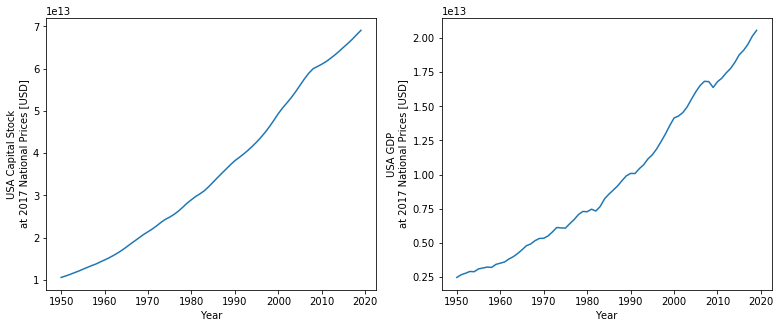

In [10]:
# Plot capital stock vs GDP changes through time Philippines
plt.figure(figsize=(13, 5))
plt.subplot(121)
pwt_phi = pwt_df[pwt_df['country']=='United States']
plt.plot(pwt_df['year'],pwt_df['rnna'])
plt.xlabel('Year')
plt.ylabel('USA Capital Stock\nat 2017 National Prices [USD]')

plt.subplot(122)
pwt_phi = pwt_df[pwt_df['country']=='United States']
plt.plot(pwt_df['year'],pwt_df['rgdpna'])
plt.xlabel('Year')
plt.ylabel('USA GDP\nat 2017 National Prices [USD]')


(0, 2000000000.0)

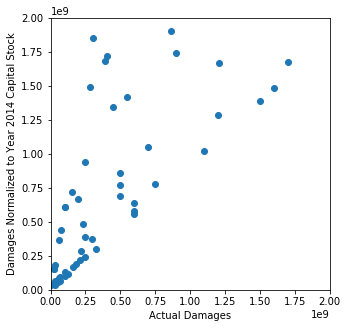

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(total_damages,total_damages_norm)
plt.xlabel('Actual Damages')
plt.ylabel('Damages Normalized to Year 2014 Capital Stock')
plt.xlim([0,0.2e10])
plt.ylim([0,0.2e10])

Text(0, 0.5, '# of Events')

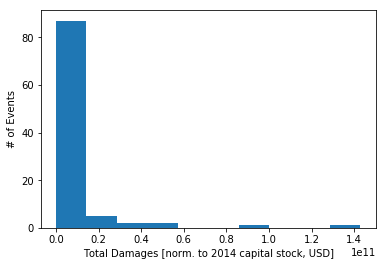

In [12]:
# Plot histogram of normalized USA TC damages
plt.hist(total_damages_norm)
plt.xlabel("Total Damages [norm. to 2014 capital stock, USD]")
plt.ylabel('# of Events')

# Plot comparing asset losses from TCs vs known damages

In [13]:
def TDR(mod,obs): # inputs are paired modeled and observed losses
    tdr = np.sum(mod)/np.sum(obs) # total damage ratio-- closest to 1 is optimal
    return tdr
def RMSF(mod,obs): # inputs are paired modeled and observed losses
    edr = mod/obs # event damage ratio
    edr_no0 = edr[np.where(edr>0)] # exclude 0 points because can't calculate log for those
    rmsf = np.exp((np.mean(np.log(edr_no0)**2))**0.5) # root-mean squared fraction-- lower = better fit
    return rmsf, edr

CPU times: user 2min 18s, sys: 8min 5s, total: 10min 24s
Wall time: 42min 12s


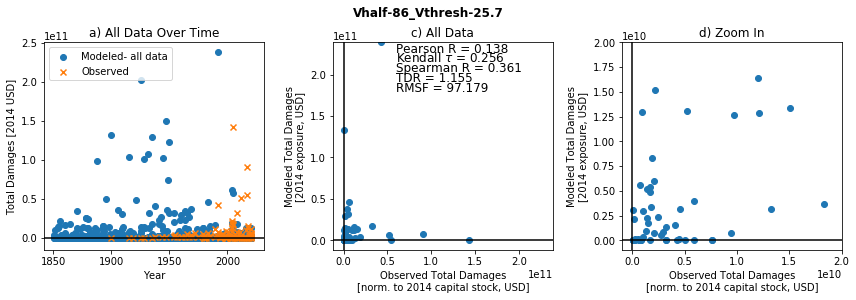

In [15]:
%%time
# Plot comparing simulated damages to observed damages
Vthresh = [25.7]# Eberenz et al 2020, 25.7 is value used for all and 10 below and above that; m/s
Vhalf = [86]# Eberenz et al 2020, value for Philippines using default, RMSF calculation, and TDR calculation; m/s

obs_paired_losses = {}
mod_paired_losses = {}
modeled_damages = {}
obs_paired_losses_ncr = {}
mod_paired_losses_ncr = {}
modeled_damages_ncr = {}
year_ncr = {}
pr = {}
ktau = {}
sr = {}
tdr = {}
rmsf = {}
edr = {}

for vt in Vthresh:
    for vh in Vhalf:
        
        # Calculate modeled damages
        label = 'Vhalf-'+str(vh)+'_Vthresh-'+str(vt)
        file_damages = label+'.nc'
        ds_damages = xr.open_dataset(direc + file_damages)
        modeled_damages[label] = ds_damages.sum(dim=['lon','lat']).asset_losses.values

        # Pair observed and modeled damages
        obs_paired_losses[label] = total_damages_norm[matches[:,0]]
        mod_paired_losses[label] = modeled_damages[label][matches[:,1]]
        
        # Calculate metrics of correlation
        pr[label] = pearsonr(mod_paired_losses[label], obs_paired_losses[label])[0]
        ktau[label] = kendalltau(mod_paired_losses[label], obs_paired_losses[label])[0]
        sr[label] = spearmanr(mod_paired_losses[label], obs_paired_losses[label])[0]
        tdr[label] = TDR(mod_paired_losses[label], obs_paired_losses[label])
        rmsf[label], edr[label] = RMSF(mod_paired_losses[label], obs_paired_losses[label])
        
        #PLOTTING
        plt.figure(figsize=(12, 4))
        # Plot time series of observed vs modeled TC damages
        ax = plt.subplot(131)
        ax.scatter(year, modeled_damages[label], label = 'Modeled- all data')
        ax.scatter(start_year/10000, total_damages_norm, marker='x', label = 'Observed')
        plt.xlabel('Year')
        plt.ylabel("Total Damages [2014 USD]")
        plt.axhline(0,color='k')
        plt.legend()
        plt.title('a) All Data Over Time')
        # All data vs plot
        ax = plt.subplot(132)
        axmax = np.nanmax(np.append(obs_paired_losses[label], mod_paired_losses[label]))
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data')
        plt.text(axmax*0.25,axmax*0.95,'Pearson R = '+str(np.round(pr[label],3)),fontsize=12)
        plt.text(axmax*0.25,axmax*0.9,r'Kendall $\tau$ = '+str(np.round(ktau[label],3)),fontsize=12)
        plt.text(axmax*0.25,axmax*0.85,'Spearman R = '+str(np.round(sr[label],3)),fontsize=12)
        plt.text(axmax*0.25,axmax*0.8,'TDR = '+str(np.round(tdr[label],3)),fontsize=12)
        plt.text(axmax*0.25,axmax*0.75,'RMSF = '+str(np.round(rmsf[label],3)),fontsize=12)
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        plt.xlim([-0.05*axmax,axmax])
        plt.ylim([-0.05*axmax,axmax])
        #plt.legend()
        plt.title('c) All Data')
        # Zoom in vs plot
        ax = plt.subplot(133)
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data')
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        plt.xlim([-0.01e11,0.2e11])
        plt.ylim([-0.01e11,0.2e11])
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        #plt.legend()
        plt.title('d) Zoom In')
        # Modifying whole plot
        plt.suptitle(label, y=1.03,fontweight='bold')
        plt.tight_layout()
        plt.savefig('FIGURES/assetlosses_usa_'+label+'.png')

In [133]:
# ANALYSIS ACROSS DIFFERENT CORRELATION METRICS

# Put all correlation statistics on grid vs Vthresh and Vhalf values for plotting
pr_grid = np.zeros((3,3))
ktau_grid = np.zeros((3,3))
sr_grid = np.zeros((3,3))
tdr_grid = np.zeros((3,3))
rmsf_grid = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        vt = Vthresh[i]
        vh = Vhalf[j]
        label = 'Vhalf-'+str(vh)+'_Vthresh-'+str(vt)
        pr_grid[i,j] = pr[label]
        ktau_grid[i,j] = ktau[label]
        sr_grid[i,j] = sr[label]
        tdr_grid[i,j] = tdr[label]
        rmsf_grid[i,j] = rmsf[label]

pr_dat = xr.DataArray(pr_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
ktau_dat = xr.DataArray(ktau_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
sr_dat = xr.DataArray(sr_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
tdr_dat = xr.DataArray(tdr_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
rmsf_dat = xr.DataArray(rmsf_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])


#PLOTTING
plt.figure(figsize=(13, 7))

ax = plt.subplot(231)
pr_dat.plot(cmap = plt.cm.Reds_r)
plt.title('Pearson R')

ax = plt.subplot(232)
ktau_dat.plot(cmap = plt.cm.Reds_r)
plt.title(r'Kendall $\tau$')

ax = plt.subplot(233)
sr_dat.plot(cmap = plt.cm.Reds_r)
plt.title('Spearman R')

ax = plt.subplot(234)
np.log(tdr_dat).plot()
plt.title('ln(TDR)')

ax = plt.subplot(235)
rmsf_dat.plot(cmap = plt.cm.Reds)
plt.title('RMSF')

plt.suptitle('Correlation between Modeled and Observed Damages via Different Metrics\n (more white = better fit)', fontweight='bold',y=1.04)
plt.tight_layout()
plt.savefig('correlations_usa.png')

KeyError: 'Vhalf-74.7_Vthresh-15.7'

Text(0, 0.5, '# of Events')

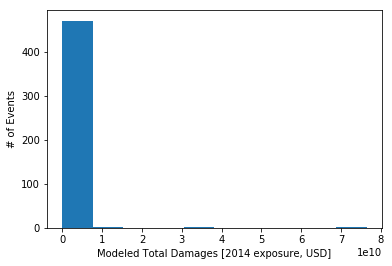

In [111]:
# Plot histogram of Philippines TC damages
plt.hist(modeled_damages)
plt.xlabel("Modeled Total Damages [2014 exposure, USD]")
plt.ylabel('# of Events')

In [167]:
# To check the matching work looked at Rammasun (Glenda)
# Modeled index = 432, damages 1.3e10
# Obs index = 221, damages 8.2e8
# Found in paired losses: [8.20576000e+08, 1.30901863e+10],

Text(0, 0.5, 'IBTrACS Start Date')

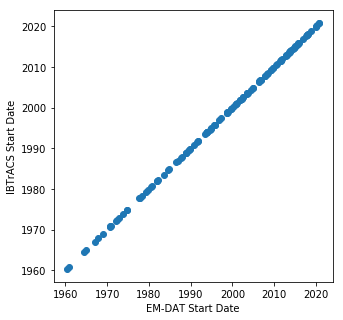

In [527]:
plt.figure(figsize=(5, 5))
plt.scatter(start_date[matches[:,0]],tc_start_date[matches[:,1]])
plt.xlabel('EM-DAT Start Date')
plt.ylabel('IBTrACS Start Date')

In [ ]:
# Try normalizing by particular year GDP